In [1]:
import sys
# sys.path.append('../src')
import exlib
import torch
from datasets import load_dataset
from exlib.datasets import massmaps
from exlib.datasets.massmaps import MassMapsConvnetForImageRegression

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Load model
model = MassMapsConvnetForImageRegression.from_pretrained(massmaps.MODEL_REPO) # BrachioLab/massmaps-conv
model = model.to(device)

In [3]:
# Load data
train_dataset = load_dataset(massmaps.DATASET_REPO, split='train') # BrachioLab/massmaps-cosmogrid-100k
val_dataset = load_dataset(massmaps.DATASET_REPO, split='validation')
test_dataset = load_dataset(massmaps.DATASET_REPO, split='test')
train_dataset.set_format('torch', columns=['input', 'label'])
val_dataset.set_format('torch', columns=['input', 'label'])
test_dataset.set_format('torch', columns=['input', 'label'])

/opt/conda/envs/rapids/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [4]:
# Baseline

from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool
import torch
import torch.nn as nn
import numpy as np

class MassMapsWatershed(nn.Module):
    def __init__(self, compactness=0, normalize=False):
        """
        compactness: Higher values result in more regularly-shaped watershed basins.
        """
        super().__init__()
        self.compactness = compactness
        self.normalize = normalize
        
    def apply_watershed(self, image):
        compactness = self.compactness
        normalize = self.normalize
        
        if normalize:
            # print('min', image.min(), 'max', image.max())
            image = (image - image.min()) / (image.max() - image.min())
            # print('after: min', image.min(), 'max', image.max())
        
        image = (image * 255).astype(np.uint8)
        distance = ndimage.distance_transform_edt(image)
        coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)
        raw_labels = watershed(-distance, markers, mask=image,
                               compactness=compactness)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, M, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_watershed(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        daf_preds = torch.nn.utils.rnn.pad_sequence(daf_preds, batch_first=True)
        return daf_preds

In [5]:
watershed_baseline = MassMapsWatershed(normalize=True).to(device)

In [6]:
# Alignment
from exlib.datasets.massmaps import MassMapsAlignment
massmaps_align = MassMapsAlignment().to(device)

In [16]:
# Eval
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
alignment_scores_all = []

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        groups = watershed_baseline(X)

        # alignment
        alignment_scores = massmaps_align(groups, X)
        alignment_scores_all.extend(alignment_scores.flatten(1).cpu().numpy().tolist())
        
        if bi > 10:
            break
            
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Omega_m loss 0.0058, sigma_8 loss 0.0095, avg loss 0.0076


In [10]:
total_score = torch.mean(torch.stack([torch.mean(torch.tensor(alignment_scores_all[i])) \
                      for i in range(len(alignment_scores_all))]))
total_score

tensor(0.5607)

# Baselines

In [17]:
# Quickshift

from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsQuickshift(nn.Module):
    def __init__(self, ratio=1.0, kernel_size=5, max_dist=10):
        """
        ratio : float, optional, between 0 and 1
            Balances color-space proximity and image-space proximity.
            Higher values give more weight to color-space.
        kernel_size : float, optional
            Width of Gaussian kernel used in smoothing the
            sample density. Higher means fewer clusters.
        max_dist : float, optional
            Cut-off point for data distances.
            Higher means fewer clusters.
        """
        super().__init__()
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.max_dist = max_dist
        
    def apply_quickshift(self, image):
        ratio = self.ratio
        kernel_size = self.kernel_size
        max_dist = self.max_dist
        
        image = (image * 255).astype(np.uint8)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        raw_labels = quickshift(image_bgr, ratio=ratio, 
                                kernel_size=kernel_size, 
                                max_dist=max_dist)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: ef (N, M, H, W)
        """
        groups_all = []
        for image in images:
            segment_mask = torch.tensor(self.apply_quickshift(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            groups_all.append(masks_bool)
        groups_all = torch.nn.utils.rnn.pad_sequence(groups_all, batch_first=True)
        return groups_all

In [18]:
# Patch

from scipy import ndimage
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool, patch_segmenter
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsPatch(nn.Module):
    def __init__(self, sz=(8, 8)):
        """
        sz : int, number of patches per side.
        """
        super().__init__()
        self.sz = sz
    
    def apply_patch(self, image):
        return patch_segmenter(image, sz=self.sz)
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, M, H, W)
        """
        groups_all = []
        for image in images:
            segment_mask = torch.tensor(self.apply_patch(image[0].cpu().numpy())).to(images.device)
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            groups_all.append(masks_bool)
        groups_all = torch.nn.utils.rnn.pad_sequence(groups_all, batch_first=True)
        return groups_all

In [25]:
# Oracle

# from skimage.segmentation import watershed, quickshift
from scipy import ndimage
# from skimage.feature import peak_local_max
# from 
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool, patch_segmenter
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsOracle(nn.Module):
    def __init__(self, sz=(8, 8)):
        """
        sz : int, number of patches per side.
        """
        super().__init__()
        self.sz = sz
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, M, H, W)
        """
        groups_all = []
        stds = torch.std(images.flatten(2), dim=-1)
        N, C, H, W = images.shape
        # import pdb; pdb.set_trace()
        masks = torch.zeros(N, 3, H, W).to(images.device)
        masks[:,0] = (images < 0)[:,0]
        masks[:,1] = (images > 3 * stds[:,:,None,None])[:,0]
        masks[:,2] = torch.logical_not(masks[:,1].logical_or(masks[:,0]))
        groups_all = masks
        return groups_all

In [28]:
# One

from scipy import ndimage
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool, patch_segmenter
import torch
import torch.nn as nn
import numpy as np
import cv2

class MassMapsOne(nn.Module):
    def __init__(self, sz=(8, 8)):
        """
        sz : int, number of patches per side.
        """
        super().__init__()
        self.sz = sz
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: masks (N, M, H, W)
        """
        stds = torch.std(images.flatten(2), dim=-1)
        N, C, H, W = images.shape
        masks = torch.ones(N, 1, H, W).to(images.device)
        return masks

# Show alignment scores examples

In [19]:
import math
import matplotlib.pyplot as plt

def show_example(groups, X, img_idx=0):
    massmaps_align = MassMapsAlignment()
    alignment_results = massmaps_align(groups, X, reduce='none')
    
    m = groups.shape[1]
    cols = 8
    rows = math.ceil(m / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axs = axs.ravel()

    image = X[img_idx]
    for idx in range(len(axs)):
        if idx < m:
            mask = groups[img_idx][idx]

            if mask.sum() > 0:
                axs[idx].imshow(image[0].cpu().numpy())
                axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
                axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                                cmap='gray', extend='neither', linestyles='--', alpha=0.01)
                p_void_ = alignment_results['p_void_']
                p_cluster_ = alignment_results['p_cluster_']
                purity = alignment_results['purity']
                # total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
                axs[idx].set_title(f'void {p_void_[0][idx].item():.5f}\ncluster {p_cluster_[0][idx].item():.5f}\npurity {purity[0][idx].item():.5f}')
        axs[idx].axis('off')
    plt.show()

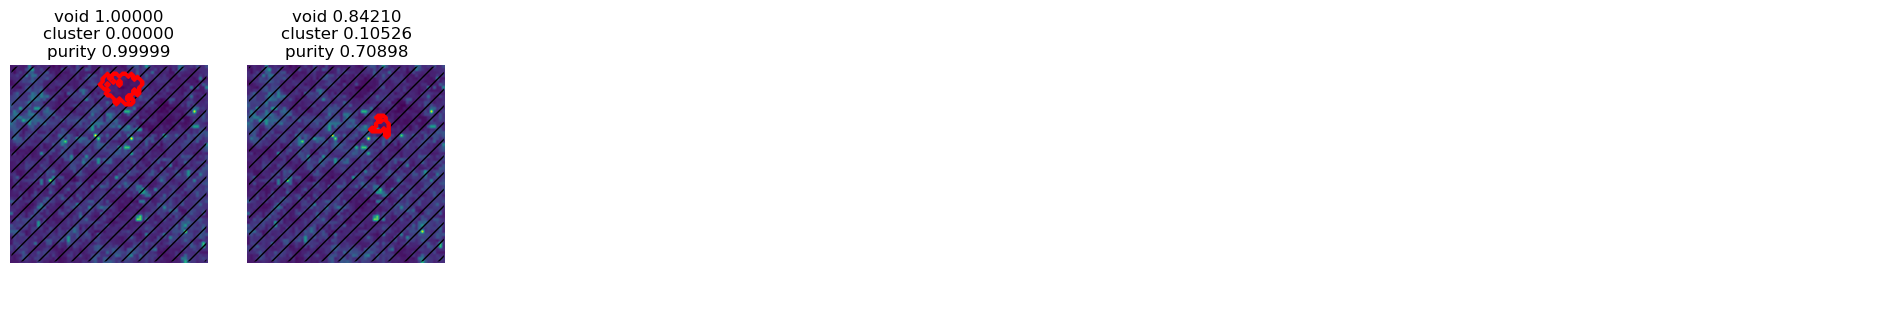

In [20]:
import torch
from exlib.datasets.massmaps import MassMapsAlignment
watershed_baseline = MassMapsWatershed().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = watershed_baseline(X)
groups_show = torch.stack([groups[0:1,2], groups[0:1,10]], dim=1)
show_example(groups_show, X[0:1])
# groups

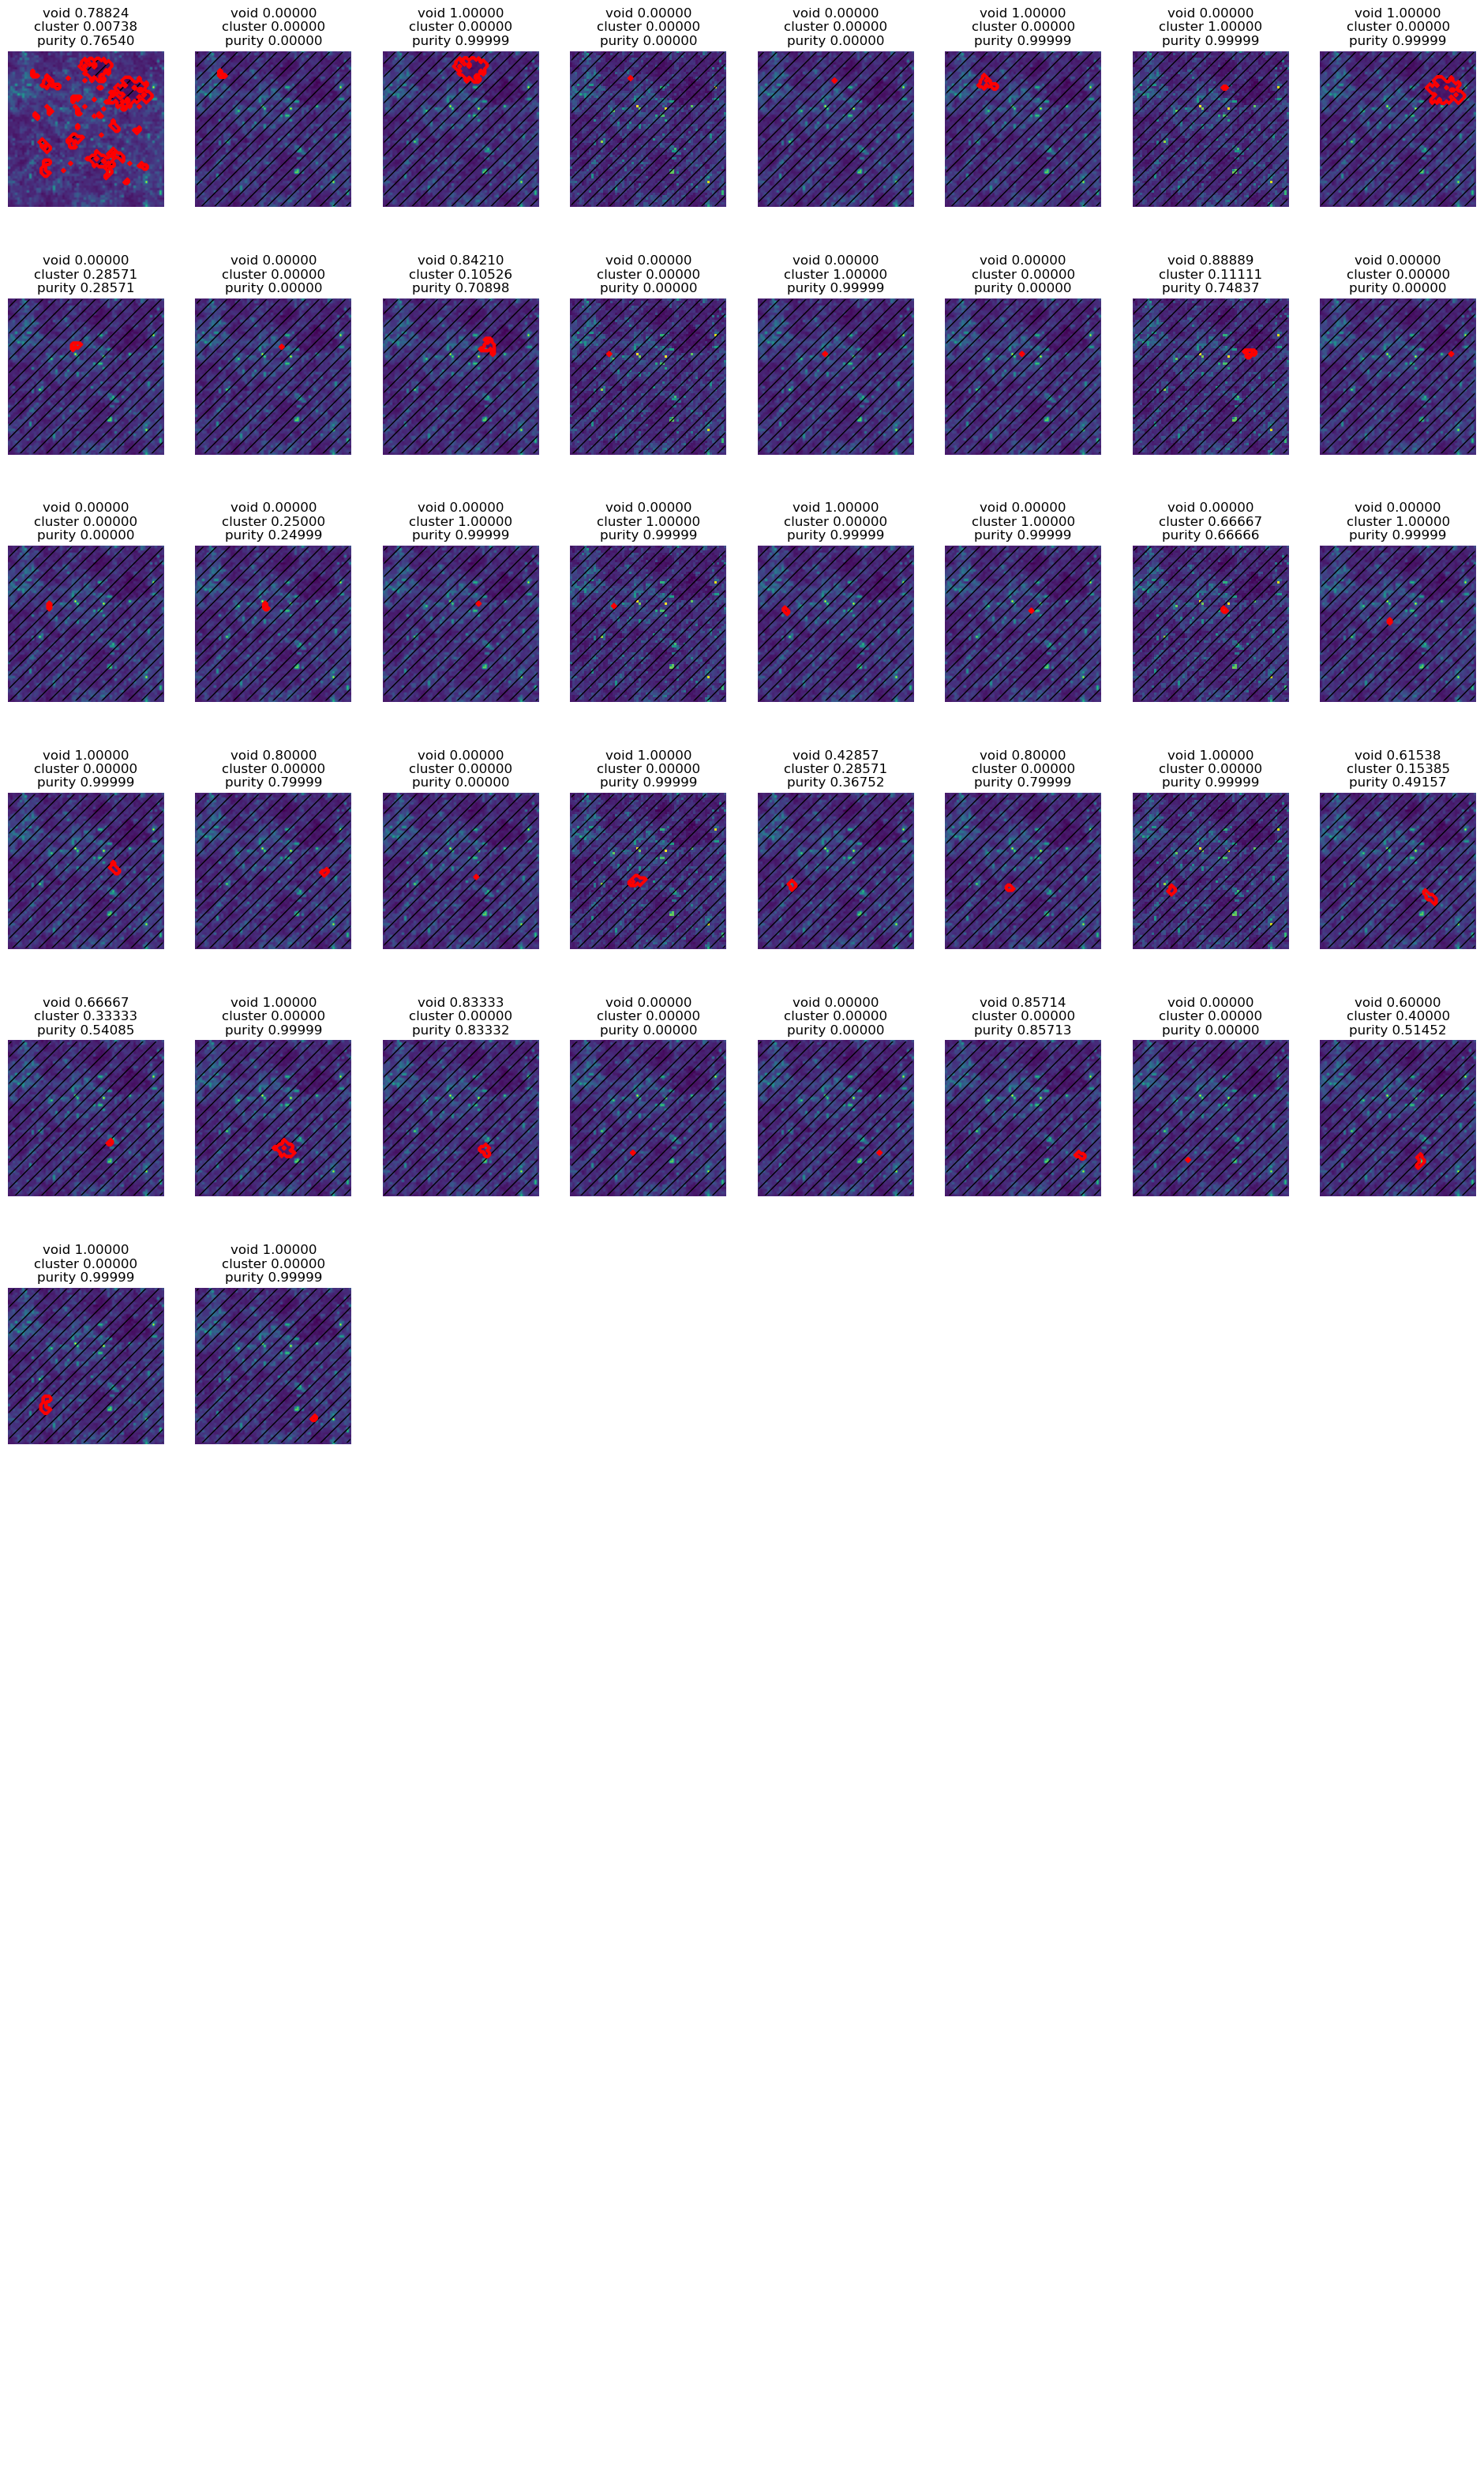

In [21]:
show_example(groups, X)

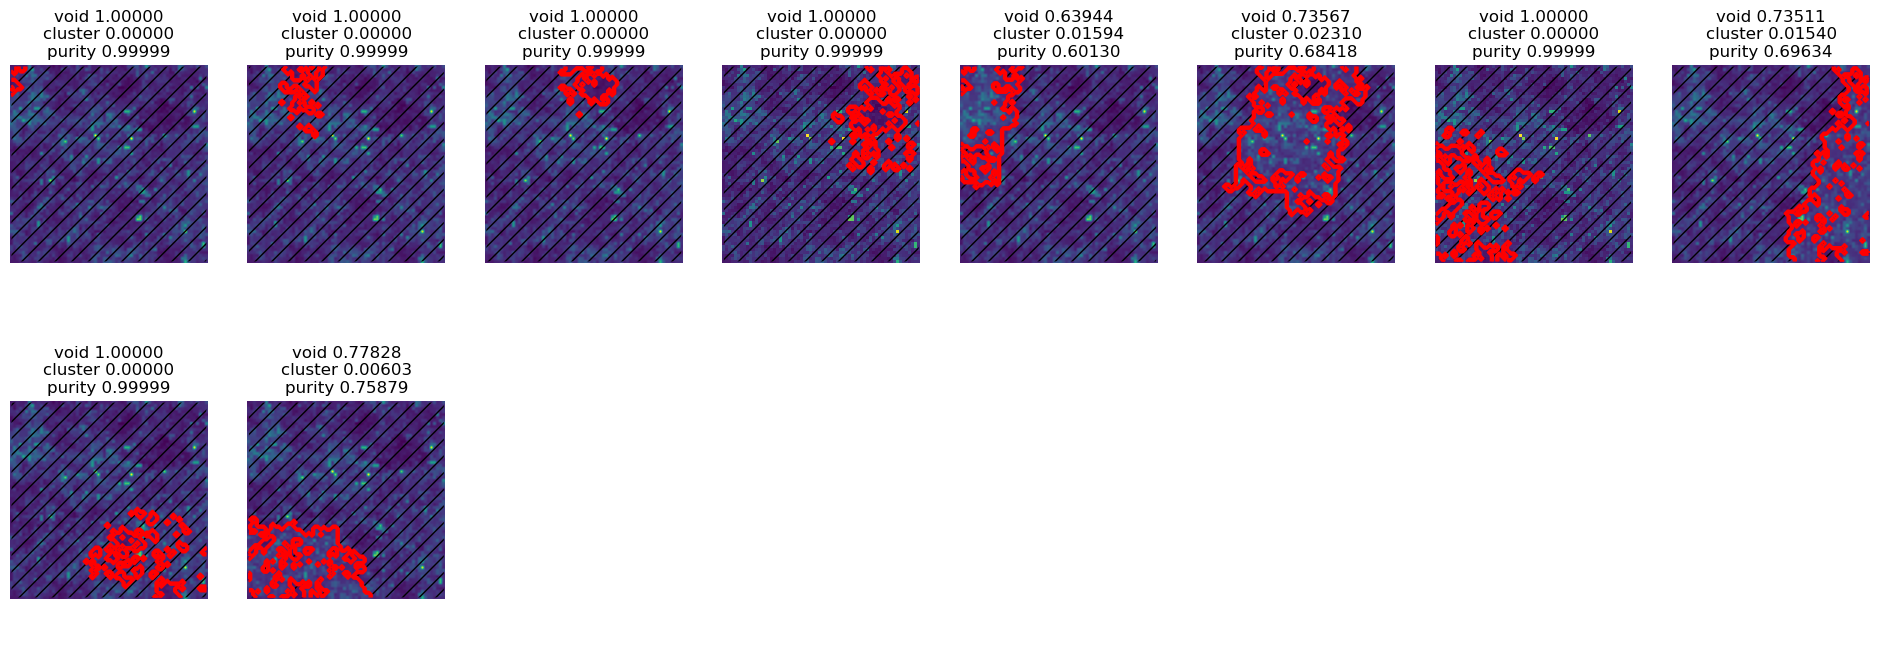

In [22]:
import matplotlib.pyplot as plt
import math

import torch
from exlib.datasets.massmaps import MassMapsAlignment
quickshift_baseline = MassMapsQuickshift().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = quickshift_baseline(X)
show_example(groups, X)
          

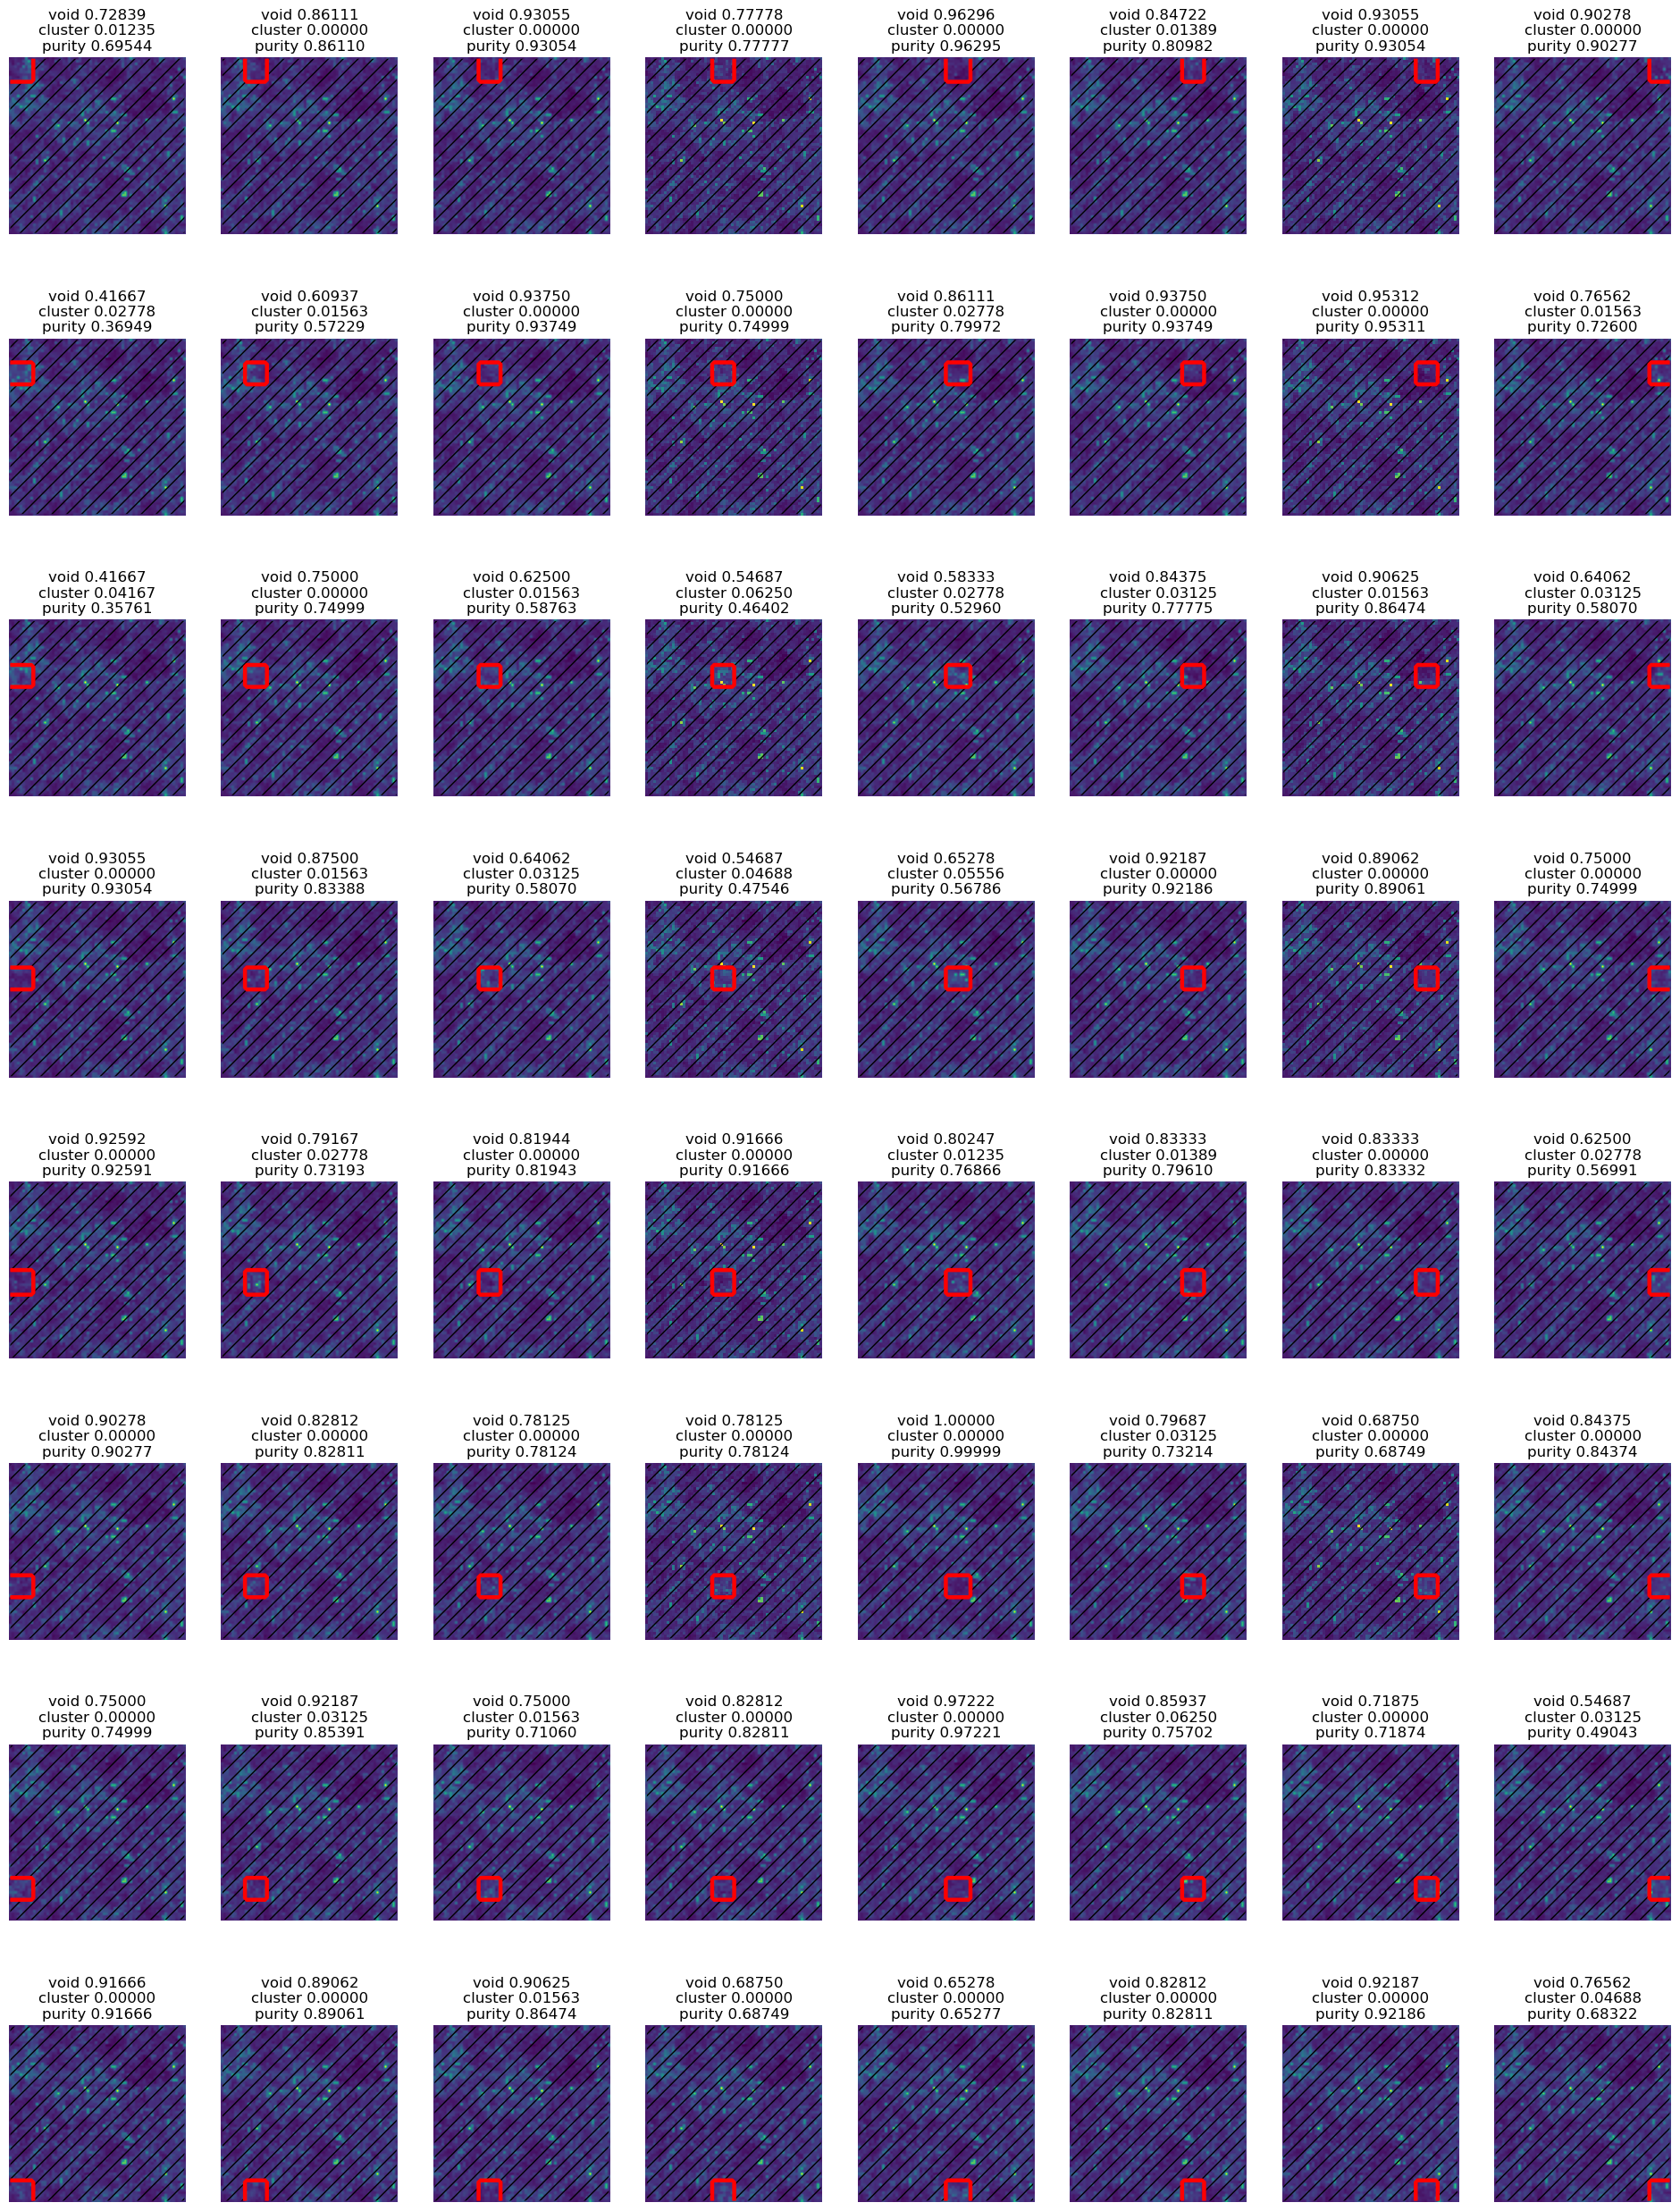

In [29]:
import matplotlib.pyplot as plt
import math

import torch
from exlib.datasets.massmaps import MassMapsAlignment
patch_baseline = MassMapsPatch().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = patch_baseline(X)
show_example(groups, X)

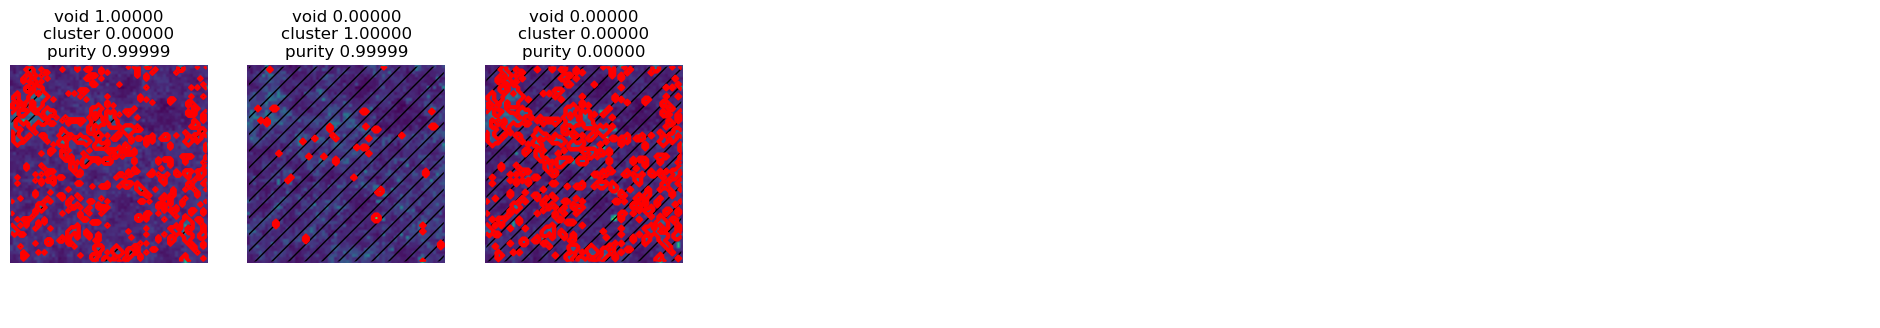

In [30]:
import matplotlib.pyplot as plt
import math

import torch
from exlib.datasets.massmaps import MassMapsAlignment
oracle_baseline = MassMapsOracle().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = oracle_baseline(X)
show_example(groups, X)

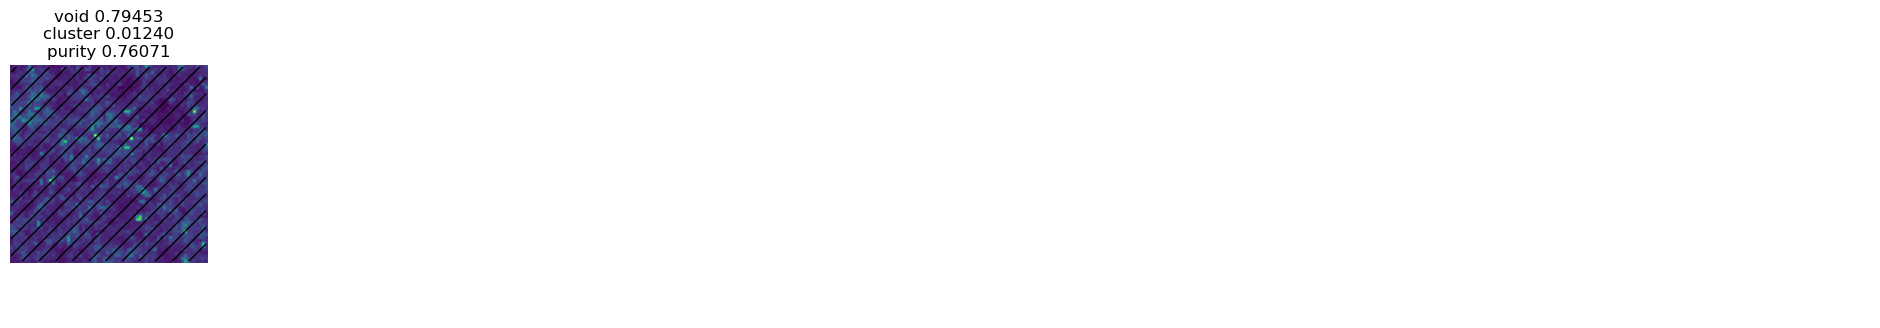

In [31]:
import matplotlib.pyplot as plt
import math

import torch
from exlib.datasets.massmaps import MassMapsAlignment
one_baseline = MassMapsOne().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = one_baseline(X)
show_example(groups, X)

# Compare baselines

In [39]:
from collections import defaultdict

# Eval
watershed_baseline = MassMapsWatershed().to(device)
quickshift_baseline = MassMapsQuickshift().to(device)
patch_baseline = MassMapsPatch().to(device)
oracle_baseline = MassMapsOracle().to(device)
one_baseline = MassMapsOne().to(device)

baselines = {
    'watershed': watershed_baseline,
    'quickshift': quickshift_baseline,
    'patch': patch_baseline,
    'oracle': oracle_baseline,
    'one': one_baseline
}

batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
alignment_scores_all = defaultdict(list)

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # if bi % 100 != 0:
        #     continue
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        for name, baseline in baselines.items():
            groups = baseline(X)

            # alignment
            alignment_scores = massmaps_align(groups, X)
            alignment_scores_all[name].extend(alignment_scores.flatten(1).cpu().numpy().tolist())
            
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

  0%|          | 0/157 [00:00<?, ?it/s]

Omega_m loss 0.0050, sigma_8 loss 0.0112, avg loss 0.0081


In [40]:
for name in alignment_scores_all:
    metric = torch.tensor(alignment_scores_all[name])
    mean_metric = metric.mean()
    print(f'{name}\t{mean_metric.item():.4f}')


watershed	0.5662
quickshift	0.5580
patch	0.5618
oracle	0.5930
one	0.5485
